In [1]:
from detectron2.config import get_cfg
from detectron2.data import DatasetCatalog, MetadataCatalog, build_detection_train_loader
from detectron2.model_zoo import model_zoo
from detectron2.utils.visualizer import Visualizer, ColorMode
from detectron2.structures import BoxMode
from io import BytesIO
import os
import cv2
import json
import numpy as np
import matplotlib.pyplot as plt
import random
import PIL.Image
import requests
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader

# This section is the evaluation of the model performances with coco panoptic with Detectron2 Framework


COCO Panoptic Metric Explanation

The COCO Panoptic Metric is a widely used evaluation measure in computer vision, specifically designed to assess the performance of algorithms and models in the context of panoptic segmentation. Panoptic segmentation is a task that unifies the understanding of both stuff (e.g., road, sky) and things (e.g., cars, people) in a scene, making it a comprehensive way to analyze and interpret images and videos.

The COCO Panoptic Metric takes into account the quality of segmentation, ensuring that objects are correctly delineated, and the understanding of the overall scene context, providing a holistic assessment of the model's performance in scene understanding.

The evaluation is typically performed by comparing the model's output to ground truth annotations. The metric is expressed as a combination of the average "thing" and "stuff" segmentation accuracies, along with the "panoptic quality," which summarizes the model's ability to capture the complete scene.  



Reference : https://www.lrde.epita.fr/dload/papers/chazalon.21.icdar.1.pdf


Installation from github : https://github.com/icdar21-mapseg/coco-pano-ext-demo

In [2]:
!python3 -m pip install coco-pano-ext-demo 

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.7/14.7 MB 30.3 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 313.3/313.3 kB 40.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.1/224.1 kB 20.5 MB/s eta 0:00:00


Here you only need to run all the cells without changing anything and a graph will show the results per class at the end.

This code cell enables you to visualize the model predictions on a selected directory of images. This is particularly useful for assessing the model's performance on tricky images or testing it against edge cases.

From the Gallica Training Notebook we get some function to build our dataset.

In [3]:
from detectron2.utils.visualizer import ColorMode
from detectron2.engine import DefaultPredictor
from data_utils import remove_all_datasets, split_data
category_dict = {
  'tampon': 0,
  'écriture manuscrite': 1,
  'écriture typographique': 2,
  'photographie': 3,
  'estampe': 4
}
#choose the model you want to train
models = ["Detectron2", "LayoutParser"]
selected_model = models[1]
gallica_json = "output/gallica_dataset_file.json"
image_dir = "../data/images"

remove_all_datasets()

datasets = split_data(gallica_json, category_dict, image_dir)

def get_dataset_dicts_split(datasets, split='train'):
    random.shuffle(datasets[0])
    random.shuffle(datasets[1])
    random.shuffle(datasets[2])
    if split == 'train':
        return datasets[0]
    elif split == 'val':
        return datasets[1]
    elif split == 'test':
        return datasets[2]

2738
count:  [ 650. 4410. 5598. 1557. 1038.]
classes_count:  [ 650. 4410. 5598. 1557. 1038.]
nb_image:  2707
data_lost 31


In [4]:
for d in ["train", "val", "test"]:
    DatasetCatalog.register("my_dataset_" + d, lambda d=d: get_dataset_dicts_split(datasets, d))
    MetadataCatalog.get("my_dataset_" + d).set(thing_classes=list(category_dict.keys()))

dataset_dicts = DatasetCatalog.get("my_dataset_test")
metadata = MetadataCatalog.get("my_dataset_test")

In [5]:
modeldata_path = "../models/"

cfg = get_cfg()

if  selected_model == "Detectron2":
    cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"))
    cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml")
elif selected_model == "LayoutParser":
    cfg.merge_from_file(modeldata_path + "config.yml")
    cfg.MODEL.WEIGHTS = modeldata_path + "Layout_parser_weights.pth"    
else :
    raise ValueError("Invalid model selected!")
    
cfg.MODEL.ROI_HEADS.NUM_CLASSES = len(category_dict)
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "test_cocopanoptic.pth")

cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.8  # set the testing threshold for this model
#Pass the validation dataset
cfg.DATASETS.TEST = ("my_dataset_val", )
predictor = DefaultPredictor(cfg)

In [6]:
def predict_directory(path):
    for file_name in os.listdir(path):
        # Read the image
        file_path = os.path.join(path, file_name)
        im = cv2.imread(file_path)

        # Measure the prediction time
        start_time = time.time()
        outputs = predictor(im)
        end_time = time.time()
        
        # Calculate the elapsed time
        elapsed_time = end_time - start_time

        print("Inference time: {:.4f} seconds, shape of {}".format(elapsed_time, im.shape))
        
        # Extract the instance masks and their associated classes
        instances = outputs["instances"].to("cpu")
        #instance_masks = instances.pred_masks.numpy()
        print(instances.pred_boxes.tensor.tolist())
        print(instances.pred_classes.tolist())

        # Visualize the predictions
        v = Visualizer(im[:, :, ::-1], metadata=metadata, scale=0.8, instance_mode=ColorMode.IMAGE)
        v = v.draw_instance_predictions(outputs["instances"].to("cpu"))

        # Display the image
        plt.imshow(v.get_image()[:, :, ::-1])
        plt.axis('off')
        plt.show()

## Creation of a binary mask for each class with the groundtruth and the prediction on the test images.

In [7]:
img_size = (400,400)

def create_mask_with_json(data, width, height):
    masks = [np.zeros(img_size, dtype=np.uint8) for x in range(len(category_dict))]
    for annotation in data["annotations"]:
        # Convert annotation units to pixel values
        x = int(annotation['bbox'][0])
        y = int(annotation['bbox'][1])
        x2 = int(annotation['bbox'][2])
        y2 = int(annotation['bbox'][3])
        
        # Scale the coordinates to match the mask size
        x_scaled = int(x * img_size[1] / width)      # New x-coordinate after scaling
        y_scaled = int(y * img_size[0] / height)     # New y-coordinate after scaling
        width_scaled = int(x2 * img_size[1] / width)    # New width after scaling
        height_scaled = int(y2 * img_size[0] / height)  # New height after scaling
        

        # Assign the corresponding label value to the pixels within the scaled bounding box
        masks[annotation["category_id"]][y_scaled:y_scaled+height_scaled, x_scaled:x_scaled+width_scaled] = 1
    
    return np.array(masks)

def create_mask_with_prediction(boxes, classes, width, height):
    masks = [np.zeros(img_size, dtype=np.uint8) for x in range(len(category_dict))]
    for i in range(len(boxes)):
        # Convert annotation units to pixel values
        x = int(boxes[i][0])
        y = int(boxes[i][1])
        x2 = int(boxes[i][2])
        y2 = int(boxes[i][3])

        # Scale the coordinates to match the mask size
        x_scaled = int(x * img_size[1] / width)      # New x-coordinate after scaling
        y_scaled = int(y * img_size[0] / height)     # New y-coordinate after scaling
        width_scaled = int(x2 * img_size[1] / width)    # New width after scaling
        height_scaled = int(y2 * img_size[0] / height)  # New height after scaling

        # Assign the corresponding label value to the pixels within the scaled bounding box
        masks[classes[i]][y_scaled:height_scaled, x_scaled:width_scaled] = 1
    
    return np.array(masks)

def predict_image(path):
    im = cv2.imread(path)
    outputs = predictor(im)
    instances = outputs["instances"].to("cpu")

    return (instances.pred_boxes.tensor.tolist(),instances.pred_classes.tolist()) 
        
groundtruth = []
predictions = []
for data in dataset_dicts:
    groundtruth.append(create_mask_with_json(data, data["width"], data["height"]))
    prediction = predict_image(data["file_name"])
    predictions.append(create_mask_with_prediction(prediction[0], prediction[1], data["width"], data["height"]))

/usr/local/lib/python3.10/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


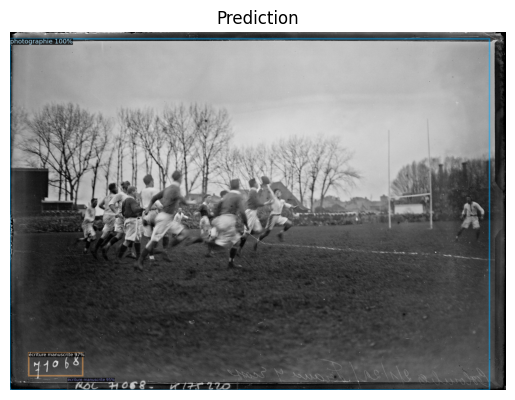

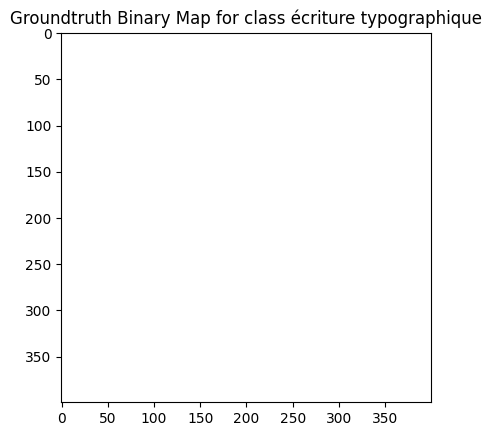

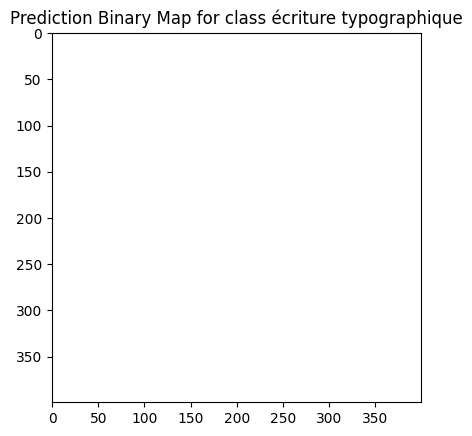

In [8]:
#This function allow you to visualize the binary masks created before, 
#the first argument is the index of the image in the test dataset and 
#the second argument is the index of the class in category_dict
def show_pred(n, class_predicted=1):
    truth = []
    for annotation in dataset_dicts[n]["annotations"]:
        l = annotation['bbox'].copy()
        l[2] += l[0]
        l[3] += l[1]
        truth.append(l)
        
    # Read the image
    im = cv2.imread(dataset_dicts[n]["file_name"])

    # Perform prediction
    outputs = predictor(im)

    # Extract the instance masks and their associated classes
    instances = outputs["instances"].to("cpu")

    # Visualize the predictions
    v = Visualizer(im[:, :, ::-1], metadata=metadata, scale=0.8, instance_mode=ColorMode.IMAGE)
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))

    # Display the image
    plt.imshow(v.get_image()[:, :, ::-1])
    plt.title('Prediction')
    plt.axis('off')
    plt.show()
    
    plt.imshow(groundtruth[n][class_predicted], cmap='binary')  # 'binary' colormap for black and white
    plt.title('Groundtruth Binary Map for class '+ list(category_dict.keys())[class_predicted])
    plt.show()

    plt.imshow(predictions[n][class_predicted], cmap='binary')  # 'binary' colormap for black and white
    plt.title('Prediction Binary Map for class '+ list(category_dict.keys())[class_predicted])
    plt.show()

show_pred(0, 2)

In [9]:
from coco_pano_ext_demo import COCO_plot, COCO
from coco_pano_ext_demo.coco import _compute_labelmap, _compute_iou
from coco_pano_ext_demo.iou import compute_matching_scores

In [10]:
def compute_matching_weights(target_binary_image, pred_binary_image) -> tuple[list[float], list[float]]:
    # computes IoUs
    wtp, wpt = 0,0
    if np.all(pred_binary_image==0):
        wtp, wpt = _compute_iou(T, T)
    elif np.all(target_binary_image==0):
        wtp, wpt = _compute_iou(P, P)
    else:
        wtp, wpt = _compute_iou(T, P)
    # remove background components
    wtp, wpt = wtp[1:], wpt[1:]
    return wtp, wpt

In [11]:
from typing import Iterable
import pandas as pd
from tqdm import tqdm
def compute_pq_score_list_single_class(targets: Iterable[np.ndarray], predictions: Iterable[np.ndarray], class_name) -> tuple[float, float, float, pd.DataFrame]:
    # Init global accumulators
    W_TtoP_global = []
    W_PtoT_global = []
    # loop over predictions (single class, TODO repeat for each class)
    for T0, P0 in tqdm(zip(targets, predictions), desc="evaluating class " + class_name, total=len(targets)):
        # Compute pairwise matching scores, exluding background
        wtp, wpt = compute_matching_weights(T0, P0)
        # Update global matching lists
        W_TtoP_global.extend(wtp.tolist())
        W_PtoT_global.extend(wpt.tolist())
    # report final score
    pairing_threshold = 0.5
    df = compute_matching_scores(np.array(W_TtoP_global), np.array(W_PtoT_global), pairing_threshold)
    COCO_SQ = df["IoU"].mean() if len(df) > 0 else 0
    COCO_RQ = df["F-score"].iloc[0] if len(df) > 0 else 0
    COCO_PQ = COCO_SQ * COCO_RQ
    
    return COCO_PQ, COCO_RQ, COCO_SQ, df

In [12]:
#get the average iou of the predictions
scores_per_class = np.zeros(len(category_dict))

for i in range(len(category_dict)):
    T = np.array(groundtruth)[:,i]
    P = np.array(predictions)[:,i]
    scores_per_class[i], COCO_RQ, COCO_SQ, df = compute_pq_score_list_single_class(T, P, list(category_dict.keys())[i])

scores_per_class

evaluating class estampe: 100%|██████████| 261/261 [01:20<00:00,  3.25it/s]


array([0.85440613, 0.54022989, 0.50957854, 0.86734423, 0.79545426])

### Model Performances

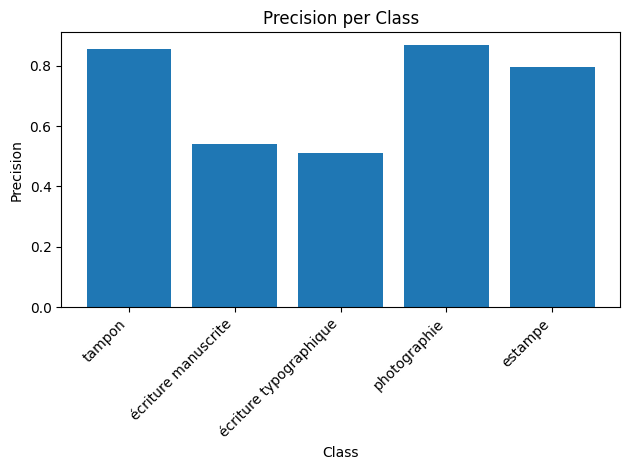

                    Class  Precision
0                  tampon   0.854406
1     écriture manuscrite   0.540230
2  écriture typographique   0.509579
3            photographie   0.867344
4                 estampe   0.795454


In [13]:
import pandas as pd
import matplotlib.pyplot as plt

# Create a DataFrame
df = pd.DataFrame({'Class': list(category_dict.keys()), 'Precision': scores_per_class})

# Remove rows with NaN precision scores
df = df.dropna(subset=['Precision'])

# Create a histogram
plt.bar(df['Class'], df['Precision'])
plt.xlabel('Class')
plt.ylabel('Precision')
plt.title('Precision per Class')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better visibility

# Show the plot
plt.tight_layout()
plt.show()
print(df)